## Importing the required libraries

In [2]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras import regularizers
import os

In [3]:
mylist= os.listdir('data/')

In [4]:
type(mylist)

list

In [5]:
print(mylist[1000])

03-01-06-02-01-02-17.wav


In [6]:


import pip


!pip install pandas




[notice] A new release of pip available: 22.1.2 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Plotting the audio file's waveform and its spectrogram

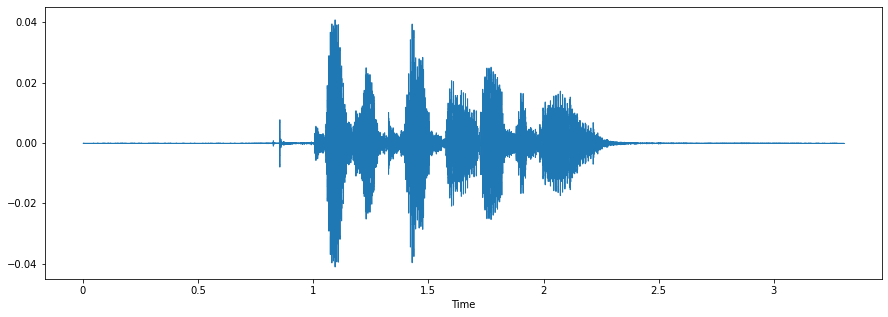

In [7]:
import os
import pandas as pd
import librosa
import glob 


data, sampling_rate = librosa.load('data/03-01-01-01-01-01-01.wav')
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

In [8]:
% pylab inline


UsageError: Line magic function `%` not found.


C:\Users\shree\AppData\Local\Temp\ipykernel_16428\1176491097.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr,x = scipy.io.wavfile.read('data/03-01-01-01-01-01-01.wav')
C:\Users\shree\AppData\Local\Temp\ipykernel_16428\1176491097.py:26: RuntimeWarning: divide by zero encountered in log
  X[i,:] = np.log(np.abs(z[:nfft//2]))


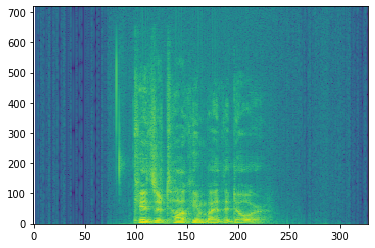

In [9]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('data/03-01-01-01-01-01-01.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Setting the labels

In [35]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    #elif item[:1]=='n':
        #feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')
    elif item[-7:-4]=='gry':
        feeling_list.append('female_angry')
    elif item[-7:-4]=='ear':
        feeling_list.append('female_fearful')
    elif item[-7:-4]=='ppy':
        feeling_list.append('female_happy')
    elif item[-7:-4]=='_ps':
        feeling_list.append('female_happy')
    elif item[-7:-4]=='sad':
        feeling_list.append('female_sad')
    

In [36]:
labels = pd.DataFrame(feeling_list)

In [37]:
labels[1200:1210]

,0
1200,female_angry
1201,female_fearful
1202,female_happy
1203,female_happy
1204,female_sad
1205,female_angry
1206,female_fearful
1207,female_happy
1208,female_happy
1209,female_sad


## Getting the features of audio files using librosa

In [38]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d' and mylist[index][-7:-4]!='ust' and mylist[index][-7:-4]!='ral':
        X, sample_rate = librosa.load('data/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [39]:
df[:5]

,feature
0,"[-70.26808, -70.26808, -70.26808, -70.26808, -..."
1,"[-65.707375, -65.707375, -63.11476, -61.5191, ..."
2,"[-65.48282, -65.48282, -65.48282, -65.48282, -..."
3,"[-64.52863, -64.52863, -64.52863, -64.52863, -..."
4,"[-63.64624, -59.995125, -61.87015, -67.49628, ..."


In [40]:
df3 = pd.DataFrame(df['feature'].values.tolist())

df3[:5]

In [41]:
newdf = pd.concat([df3,labels], axis=1)

In [42]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [43]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-57.447964,-58.897030,-58.751503,-57.406185,-60.078960,-63.427284,-62.639057,-61.242519,-61.356304,male_calm
1,-65.707375,-65.707375,-63.114761,-61.519100,-61.097507,-63.424744,-63.720127,-56.854958,-55.169304,-54.640343,...,-39.792599,-40.614021,-41.209984,-41.439613,-43.994675,-49.399967,-50.591972,-49.112217,-48.155739,female_calm
2,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,...,-31.348972,-34.310616,-35.803104,-35.938644,-37.633038,-40.119915,-41.663399,-41.552986,-41.974155,male_calm
3,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-65.928391,...,-48.674789,-48.596626,-47.603218,-43.049660,-42.660038,-43.189026,-44.001690,-43.328537,-42.985413,female_calm
4,-63.646240,-59.995125,-61.870152,-67.496277,-71.072220,-65.680321,-63.394951,-65.503853,-61.858971,-60.007893,...,-39.072914,-41.896793,-40.866905,-38.293262,-36.375126,-37.914909,-40.027390,-43.315861,-44.848812,male_calm


In [45]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
87,-63.364845,-63.364845,-63.364845,-63.364845,-63.364845,-63.364845,-63.364845,-63.364845,-63.364845,-63.364845,...,-55.843956,-54.328556,-53.345562,-53.183853,-56.202873,-57.592247,-57.460030,-56.774979,-58.431625,female_calm
248,-68.526108,-68.526108,-68.526108,-68.526108,-68.526108,-68.526108,-68.526108,-68.526108,-68.526108,-68.526108,...,-52.046230,-50.952785,-53.751423,-53.290855,-50.155472,-52.889248,-56.618332,-56.879353,-58.425728,male_happy
1720,-15.861827,-20.171774,-31.404421,-31.548998,-29.916237,-28.732637,-30.580423,-31.365074,-32.023121,-31.663792,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,female_angry
874,-52.348656,-51.636501,-52.250465,-52.348656,-51.138523,-50.790157,-50.324368,-48.709213,-50.398674,-50.990425,...,-51.498878,-51.120422,-52.060642,-51.560349,-50.819538,-49.372002,-49.712589,-50.936794,-50.387039,male_fearful
215,-64.678558,-64.678558,-64.678558,-64.678558,-64.678558,-64.678558,-64.678558,-64.678558,-64.678558,-64.678558,...,-61.665970,-61.047615,-59.299908,-60.432522,-62.516026,-64.088455,-64.658035,-64.621498,-64.705902,female_happy
1065,-8.728527,-12.916338,-24.266109,-23.484995,-24.579956,-25.052586,-25.599949,-24.285431,-24.700199,-24.941069,...,-11.562838,-13.813634,-16.836561,-19.418755,-20.164509,-22.894300,-22.463692,-18.353518,-14.955710,male_fearful
863,-55.793056,-55.846516,-55.693203,-55.668888,-55.983147,-56.143303,-56.127831,-55.966446,-55.947220,-55.989155,...,-25.449947,-26.667126,-28.593851,-29.937859,-29.609690,-31.827080,-36.193859,-37.321804,-38.598083,female_fearful
343,-54.820000,-49.662727,-48.363815,-51.363976,-48.721931,-49.667118,-49.012001,-48.350056,-49.691528,-51.470451,...,-40.396854,-41.468220,-41.572063,-40.032677,-41.190498,-44.170097,-44.218552,-42.955967,-43.427208,female_happy
2882,-18.716265,-21.051201,-23.210873,-20.125498,-18.521755,-21.240520,-22.897966,-23.331930,-23.970005,-23.185120,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,female_happy
1655,-19.169676,-20.928698,-30.523745,-34.211044,-34.310280,-33.773457,-33.800835,-32.307194,-31.099571,-32.145973,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,female_angry


In [46]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [47]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [48]:
train

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
87,-63.364845,-63.364845,-63.364845,-63.364845,-63.364845,-63.364845,-63.364845,-63.364845,-63.364845,-63.364845,...,-55.843956,-54.328556,-53.345562,-53.183853,-56.202873,-57.592247,-57.460030,-56.774979,-58.431625,female_calm
248,-68.526108,-68.526108,-68.526108,-68.526108,-68.526108,-68.526108,-68.526108,-68.526108,-68.526108,-68.526108,...,-52.046230,-50.952785,-53.751423,-53.290855,-50.155472,-52.889248,-56.618332,-56.879353,-58.425728,male_happy
1720,-15.861827,-20.171774,-31.404421,-31.548998,-29.916237,-28.732637,-30.580423,-31.365074,-32.023121,-31.663792,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,female_angry
215,-64.678558,-64.678558,-64.678558,-64.678558,-64.678558,-64.678558,-64.678558,-64.678558,-64.678558,-64.678558,...,-61.665970,-61.047615,-59.299908,-60.432522,-62.516026,-64.088455,-64.658035,-64.621498,-64.705902,female_happy
1065,-8.728527,-12.916338,-24.266109,-23.484995,-24.579956,-25.052586,-25.599949,-24.285431,-24.700199,-24.941069,...,-11.562838,-13.813634,-16.836561,-19.418755,-20.164509,-22.894300,-22.463692,-18.353518,-14.955710,male_fearful
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,-55.448547,-55.448547,-55.448547,-55.448547,-55.448547,-55.448547,-55.448547,-55.448547,-55.448547,-55.448547,...,-55.448547,-55.448547,-55.448547,-55.448547,-55.448547,-55.448547,-55.448547,-55.391323,-55.448547,male_angry
2653,-25.351244,-25.646275,-27.674452,-30.561558,-36.505585,-37.482933,-37.555729,-32.444401,-29.815592,-29.604321,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,female_happy
1185,-18.450113,-22.351265,-29.284975,-29.988678,-31.558012,-32.286369,-34.380898,-35.463631,-36.185555,-35.876564,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,female_angry
3181,-20.767036,-23.576260,-25.762096,-20.282789,-21.024275,-23.234873,-25.916758,-28.242348,-26.199125,-18.618057,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,female_fearful


In [49]:
trainfeatures = train.iloc[:, :-1]

In [50]:
trainlabel = train.iloc[:, -1:]

In [51]:
testfeatures = test.iloc[:, :-1]

In [52]:
testlabel = test.iloc[:, -1:]

In [53]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


c:\Users\shree\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [55]:
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [56]:
X_train.shape

(2585, 216)

## Changing dimension for CNN model

In [57]:

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [58]:



model = Sequential()

model.add(Conv1D(256, 5,padding='same',input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

c:\Users\shree\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [59]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 216, 256)          1536      
                                                                 
 activation_5 (Activation)   (None, 216, 256)          0         
                                                                 
 conv1d_5 (Conv1D)           (None, 216, 128)          163968    
                                                                 
 activation_6 (Activation)   (None, 216, 128)          0         
                                                                 
 dropout_1 (Dropout)         (None, 216, 128)          0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 27, 128)          0         
 1D)                                                             
                                                      

In [60]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

### Removed the whole training part for avoiding unnecessary long epochs list

In [62]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700, validation_data=(x_testcnn, y_test))

Epoch 1/700
162/162 [==============================] - 9s 53ms/step - loss: 1.6733 - accuracy: 0.4271 - val_loss: 1.5722 - val_accuracy: 0.4488
Epoch 2/700
162/162 [==============================] - 8s 46ms/step - loss: 1.4683 - accuracy: 0.4708 - val_loss: 1.4568 - val_accuracy: 0.4748
Epoch 3/700
162/162 [==============================] - 7s 46ms/step - loss: 1.3826 - accuracy: 0.4781 - val_loss: 1.4045 - val_accuracy: 0.4569
Epoch 4/700
162/162 [==============================] - 7s 46ms/step - loss: 1.3360 - accuracy: 0.4890 - val_loss: 1.3742 - val_accuracy: 0.4504
Epoch 5/700
162/162 [==============================] - 7s 46ms/step - loss: 1.3091 - accuracy: 0.4979 - val_loss: 1.3371 - val_accuracy: 0.4829
Epoch 6/700
162/162 [==============================] - 7s 46ms/step - loss: 1.2836 - accuracy: 0.5188 - val_loss: 1.3159 - val_accuracy: 0.4927
Epoch 7/700
162/162 [==============================] - 7s 46ms/step - loss: 1.2647 - accuracy: 0.5188 - val_loss: 1.2964 - val_accuracy:

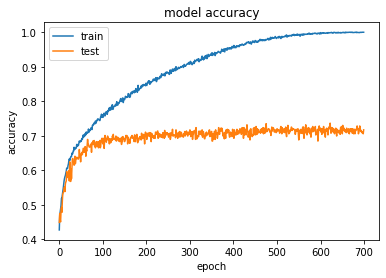

In [63]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [64]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at c:\Users\shree\Dropbox\My PC (LAPTOP-2I0PGP99)\Desktop\Speech-Emotion-Analyzer-master\Speech-Emotion-Analyzer-master\saved_models\Emotion_Voice_Detection_Model.h5 


In [65]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [66]:
# loading json and creating model

from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 71.71%


## Predicting emotions on the test data

In [67]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

20/20 [==============================] - 0s 18ms/step


In [68]:
preds

array([[1.6391169e-10, 7.3900776e-19, 2.6712621e-07, ..., 7.2688586e-01,
        2.7141854e-01, 8.6622094e-06],
       [6.8671811e-01, 4.3966451e-32, 3.1328186e-01, ..., 1.1189803e-18,
        1.3726807e-14, 3.4554662e-20],
       [5.1359899e-09, 4.8601517e-10, 3.3990472e-10, ..., 9.8920679e-01,
        7.2275279e-03, 2.6109615e-06],
       ...,
       [5.3443499e-09, 0.0000000e+00, 1.0000000e+00, ..., 1.3411238e-20,
        1.3679699e-15, 2.7609725e-15],
       [1.3493113e-06, 4.2058453e-32, 9.9999869e-01, ..., 1.3562124e-26,
        3.1753393e-20, 4.4152017e-21],
       [3.7062124e-05, 3.6407684e-07, 1.6319997e-10, ..., 1.0682365e-01,
        2.0214864e-03, 8.8578546e-01]], dtype=float32)

In [69]:
preds1=preds.argmax(axis=1)

In [70]:
preds1

array([7, 0, 7, 5, 3, 0, 9, 1, 2, 3, 6, 1, 4, 0, 3, 2, 3, 4, 0, 2, 6, 0,
       0, 0, 8, 3, 7, 0, 3, 7, 2, 0, 3, 2, 0, 0, 4, 5, 1, 3, 4, 0, 3, 3,
       0, 9, 5, 3, 9, 8, 4, 3, 3, 0, 2, 7, 4, 0, 5, 3, 5, 3, 4, 3, 3, 0,
       2, 3, 2, 3, 0, 2, 2, 7, 3, 0, 2, 0, 3, 2, 3, 4, 3, 8, 5, 0, 3, 6,
       0, 7, 5, 4, 0, 3, 3, 0, 3, 3, 4, 2, 2, 2, 0, 0, 3, 3, 2, 2, 8, 0,
       4, 2, 0, 2, 3, 3, 3, 3, 0, 2, 7, 4, 3, 3, 4, 3, 2, 5, 7, 4, 4, 3,
       6, 4, 3, 2, 3, 2, 8, 5, 3, 8, 2, 2, 0, 3, 4, 0, 4, 0, 3, 3, 3, 8,
       2, 4, 3, 4, 0, 9, 5, 4, 2, 8, 7, 3, 3, 3, 1, 3, 3, 3, 0, 3, 8, 4,
       2, 4, 0, 7, 3, 2, 3, 3, 4, 3, 0, 3, 3, 7, 3, 3, 2, 2, 4, 4, 0, 3,
       2, 4, 0, 3, 0, 2, 2, 7, 5, 9, 9, 4, 2, 2, 2, 5, 9, 0, 4, 4, 8, 5,
       8, 4, 0, 3, 4, 7, 7, 5, 3, 6, 3, 3, 9, 0, 4, 3, 6, 3, 7, 3, 3, 1,
       0, 4, 4, 0, 3, 3, 2, 4, 7, 3, 3, 3, 4, 2, 3, 0, 5, 3, 2, 3, 8, 3,
       3, 0, 7, 3, 3, 7, 1, 3, 2, 1, 4, 3, 3, 4, 3, 3, 3, 4, 8, 0, 3, 3,
       0, 3, 3, 0, 5, 2, 2, 3, 8, 4, 4, 0, 8, 2, 3,

In [71]:
abc = preds1.astype(int).flatten()

In [72]:
predictions = (lb.inverse_transform((abc)))

In [73]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_fearful
1,female_angry
2,male_fearful
3,male_angry
4,female_happy
5,female_angry
6,male_sad
7,female_calm
8,female_fearful
9,female_happy


In [74]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [75]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_fearful
1,female_angry
2,male_happy
3,male_angry
4,female_happy
5,female_angry
6,male_calm
7,female_calm
8,female_fearful
9,female_happy


In [76]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [77]:
finaldf[170:180]

,actualvalues,predictedvalues
170,female_happy,female_happy
171,female_happy,female_happy
172,female_angry,female_angry
173,female_happy,female_happy
174,male_angry,male_happy
175,female_sad,female_sad
176,female_fearful,female_fearful
177,female_calm,female_sad
178,female_angry,female_angry
179,male_fearful,male_fearful


In [78]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,100
female_calm,20
female_fearful,90
female_happy,179
female_sad,92
male_angry,30
male_calm,21
male_fearful,28
male_happy,29


In [79]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,99
female_calm,15
female_fearful,92
female_happy,177
female_sad,95
male_angry,27
male_calm,13
male_fearful,36
male_happy,36


In [80]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

#### The file 'output10.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

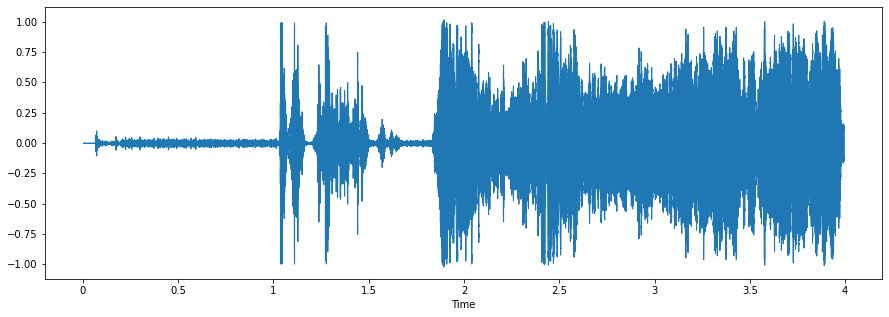

In [81]:

import os
import pandas as pd
import librosa
import glob 
data, sampling_rate = librosa.load('output10.wav')
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

In [82]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('output10.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [83]:
livedf2= pd.DataFrame(data=livedf2)

In [84]:
livedf2 = livedf2.stack().to_frame().T

In [85]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-14.903135,-12.024044,-10.986745,-10.814155,-10.5551,-12.114091,-11.416162,-10.8788,-10.985632,-10.790455,...,-7.413092,-5.366463,-4.313209,-4.353688,-1.390761,-1.878835,-8.503116,-23.69949,-24.901548,-24.68165


In [86]:
twodim= np.expand_dims(livedf2, axis=2)

In [87]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 22ms/step


In [88]:
livepreds

array([[1.9260156e-36, 0.0000000e+00, 7.1812039e-28, 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 7.9496161e-38,
        3.5602412e-16, 9.3451204e-25]], dtype=float32)

In [89]:
livepreds1=livepreds.argmax(axis=1)

In [90]:
liveabc = livepreds1.astype(int).flatten()

In [92]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['male_angry'], dtype=object)

In [ ]:
a="YAF_youth_sad.wav"
if(a[-7:-4]=='sad'):
    print("a")
elif(a[-7:-4]=='rdl'):
    print('aa')


a


In [ ]:
b="03-01-04-02-01-01-16.wav"
print(b[6:-16])

04


In [ ]:
v="h01"
print(v[:1])

h
